In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt


# **Génération d'un graphe simple**
def generate_simple_graph(num_nodes=10, max_edges=3):
    G = nx.Graph()
    for node in range(num_nodes):
        G.add_node(node)
    for node in range(num_nodes):
        neighbors = random.sample(range(num_nodes), k=min(max_edges, num_nodes - 1))
        for neighbor in neighbors:
            if node != neighbor and not G.has_edge(node, neighbor):
                G.add_edge(node, neighbor, weight=random.randint(1, 10))
    return G


In [2]:

# **Affichage des arêtes avec leurs poids**
def print_edges_with_weights(G):
    edges = [(u, v, G[u][v]['weight']) for u, v in G.edges()]
    print("Arêtes avec poids :")
    for u, v, weight in edges:
        print(f"({u}, {v}) -> Poids: {weight}")


In [3]:


# **Affichage du tableau cmatch**
def display_cmatch(cmatch):
    print("\nTableau cmatch (Nœud -> Groupe) :")
    for node, group in enumerate(cmatch):
        print(f"Nœud {node} -> Groupe {group}")
    print("-" * 30)


In [4]:


# **Encadrer les groupes sur un graphique**
def plot_groups(G, groups, title):
    pos = nx.spring_layout(G, seed=42)  # Recalculate positions for the current graph
    colors = ['red', 'blue', 'green', 'purple', 'orange']

    plt.figure(figsize=(8, 8))
    for i, group in enumerate(groups):
        valid_nodes = [n for n in group if n in G.nodes()]  # Ensure only existing nodes
        nx.draw_networkx_nodes(
            G, pos, nodelist=valid_nodes,
            node_color=colors[i % len(colors)],
            edgecolors='black'
        )

    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_color='black')

    plt.title(title)
    plt.axis('off')
    plt.show()


In [5]:

# **Contraction des nœuds avec tableau cmatch**
def contract_graph(G):
    nodes = list(G.nodes())
    random.shuffle(nodes)
    cmatch = [-1] * len(nodes)
    group_id = 0

    for node in nodes:
        if cmatch[node] == -1:
            neighbors = [n for n in G.neighbors(node) if cmatch[n] == -1]
            if neighbors:
                match = max(neighbors, key=lambda x: G[node][x]['weight'])
                cmatch[node] = group_id
                cmatch[match] = group_id
                group_id += 1
            else:
                cmatch[node] = group_id
                group_id += 1

    display_cmatch(cmatch)  # Affiche le tableau cmatch à chaque contraction

    new_G = nx.Graph()
    for u, v, data in G.edges(data=True):
        group_u = cmatch[u]
        group_v = cmatch[v]
        if group_u != group_v:
            if not new_G.has_edge(group_u, group_v):
                new_G.add_edge(group_u, group_v, weight=data['weight'])
            else:
                new_G[group_u][group_v]['weight'] += data['weight']

    return new_G, cmatch

In [6]:

# **Partitionnement initial**
def partition_graph(G, k=2):
    nodes = list(G.nodes())
    partitions = {i: [] for i in range(k)}
    for i, node in enumerate(nodes):
        partitions[i % k].append(node)
    return partitions



In [7]:

# **Pipeline METIS**
def metis_pipeline(G, k=2):
    print_edges_with_weights(G)
    plot_groups(G, [[n] for n in G.nodes()], "Graphe original avec nœuds individuels")

    while len(G.nodes()) > k:
        G, cmatch = contract_graph(G)
        groups = [[node for node, group in enumerate(cmatch) if group == g] for g in set(cmatch)]
        plot_groups(G, groups, f"Graphe contracté (taille: {len(G.nodes())})")

    partitions = partition_graph(G, k)
    groups = list(partitions.values())
    plot_groups(G, groups, "Partition finale")

    return partitions


Arêtes avec poids :
(0, 7) -> Poids: 3
(0, 5) -> Poids: 3
(0, 3) -> Poids: 10
(0, 2) -> Poids: 2
(1, 8) -> Poids: 9
(1, 2) -> Poids: 6
(1, 5) -> Poids: 10
(1, 6) -> Poids: 7
(1, 7) -> Poids: 10
(2, 6) -> Poids: 2
(2, 7) -> Poids: 7
(2, 3) -> Poids: 3
(2, 4) -> Poids: 6
(2, 8) -> Poids: 8
(2, 9) -> Poids: 2
(3, 6) -> Poids: 8
(3, 9) -> Poids: 5
(3, 8) -> Poids: 4
(4, 9) -> Poids: 4
(4, 8) -> Poids: 5
(4, 7) -> Poids: 10
(5, 7) -> Poids: 9
(6, 7) -> Poids: 5
(6, 8) -> Poids: 2
(6, 9) -> Poids: 4


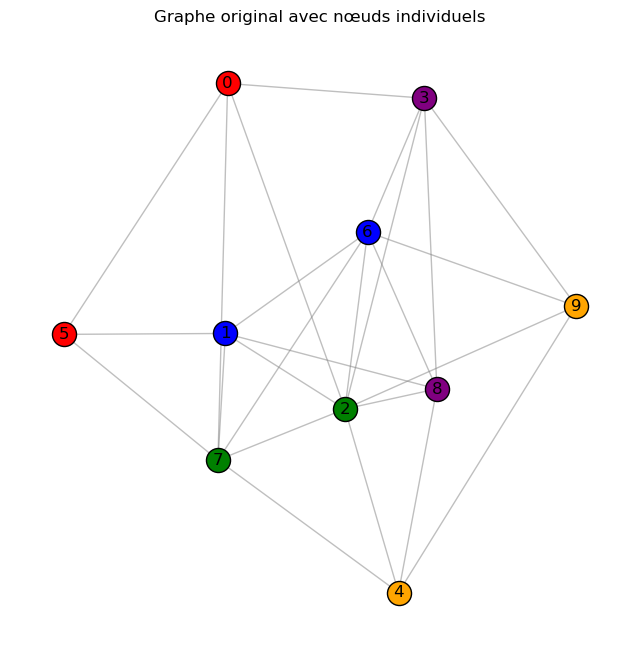


Tableau cmatch (Nœud -> Groupe) :
Nœud 0 -> Groupe 1
Nœud 1 -> Groupe 0
Nœud 2 -> Groupe 2
Nœud 3 -> Groupe 1
Nœud 4 -> Groupe 4
Nœud 5 -> Groupe 0
Nœud 6 -> Groupe 3
Nœud 7 -> Groupe 3
Nœud 8 -> Groupe 2
Nœud 9 -> Groupe 4
------------------------------


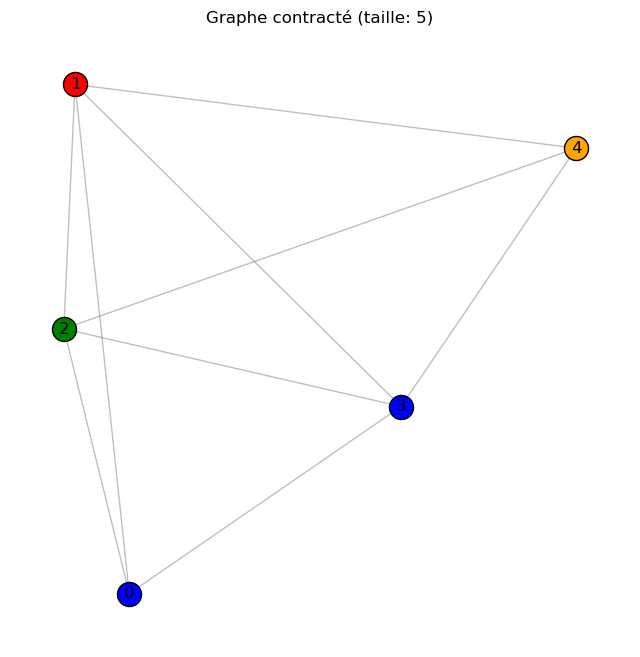


Tableau cmatch (Nœud -> Groupe) :
Nœud 0 -> Groupe 0
Nœud 1 -> Groupe 2
Nœud 2 -> Groupe 0
Nœud 3 -> Groupe 1
Nœud 4 -> Groupe 1
------------------------------


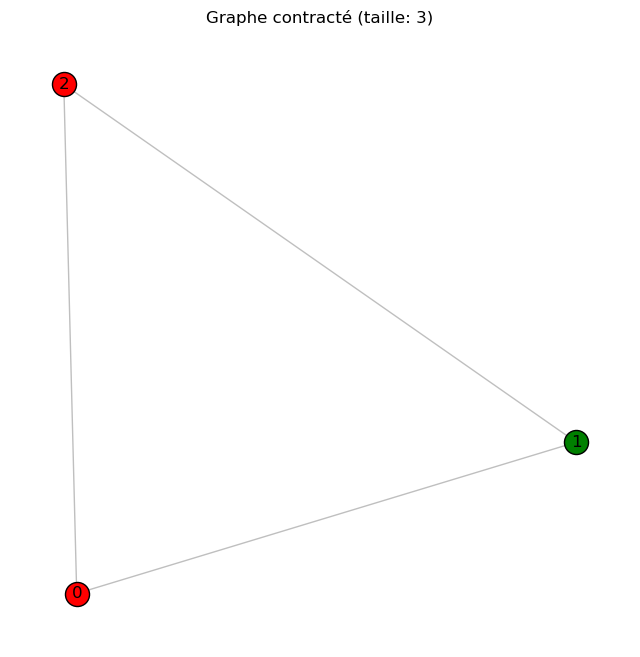

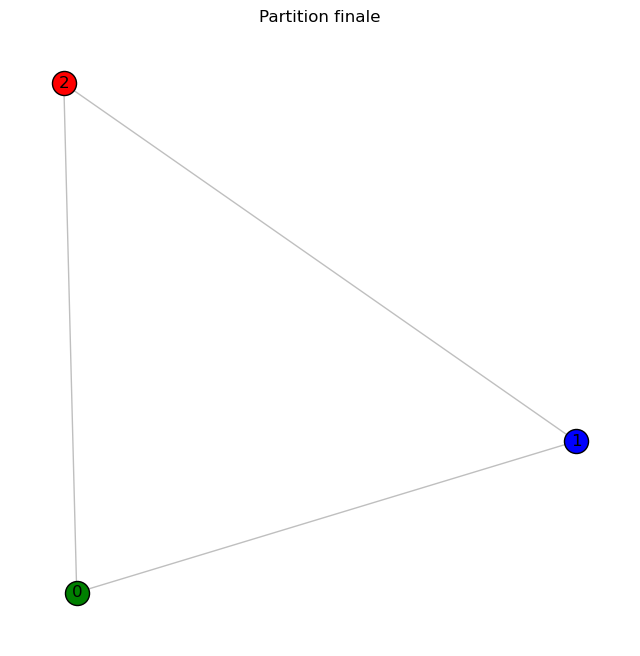

Partitions finales : {0: [2], 1: [1], 2: [0]}


In [8]:

# **Test de l'algorithme**
if __name__ == "__main__":
    G = generate_simple_graph(num_nodes=10, max_edges=3)
    partitions = metis_pipeline(G, k=3)
    print("Partitions finales :", partitions)